In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing

#tf.config.set_visible_devices([], 'GPU')
np.set_printoptions(suppress=True)

2021-10-08 16:32:15.840695: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-10-08 16:32:15.840779: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [238]:
class LabelEncoder:
    
    def __init__(self, num_points):
        self.num_points = num_points
    
    def encode(self, chromatogram, locs, scales, asymmetries):

        for loc, scale, asymmetry in zip(locs, scales, asymmetries):
            left = np.clip(int((loc-3*scale*(1-asymmetry*3)) * self.num_points), 0, self.num_points)
            right = np.clip(int((loc+3*scale*(1+asymmetry*3)) * self.num_points), 0, self.num_points)
            
        left /= self.num_points
        right /= self.num_points
        
        return [left, right]
            
    def decode(self, predictions, threshold=0.5):
        left = int(predictions[0] * self.num_points)
        right = int(predictions[1] * self.num_points)
        return [left, right]

encoder = LabelEncoder(2048)


In [247]:
def asymmetrical_gaussian_peak(x, amplitude, loc, scale, asymmetry):
    # assymetrical_gaussian_peak(..., assymetry=0) is the same as gaussian_peak(...)
    return amplitude * np.exp(-1/2*((x - loc)/(scale + asymmetry*(x - loc)))**2)

def generate_example(_):
    np.random.seed(_)
    t = np.linspace(0, 1, 2048)
    loc = np.random.uniform(0.25, 0.25)
    scale = np.random.uniform(0.02, 0.02)
    amplitude = np.random.uniform(1.0, 1.0)
    asymmetry = np.random.uniform(-0., 0.)

    g = asymmetrical_gaussian_peak(t, amplitude, loc, scale, asymmetry)

   # g += np.random.randn(g.shape[0]) * np.random.uniform(0, .005)
    #g += np.random.uniform(-.010, .010)
    #g += np.linspace(0, 1, len(g)) * np.random.uniform(-.020, .020)
    y = encoder.encode(g, [loc], [scale], [asymmetry])
    
    return g, y

with multiprocessing.Pool() as pool:
    data = [i for i in tqdm(pool.imap(generate_example, range(32)), total=32)]
    

y = np.stack([d[1] for d in data])
X = np.stack([d[0] for d in data])[..., None]
t = np.linspace(0, 1, 2048)


  0%|          | 0/32 [00:00<?, ?it/s]

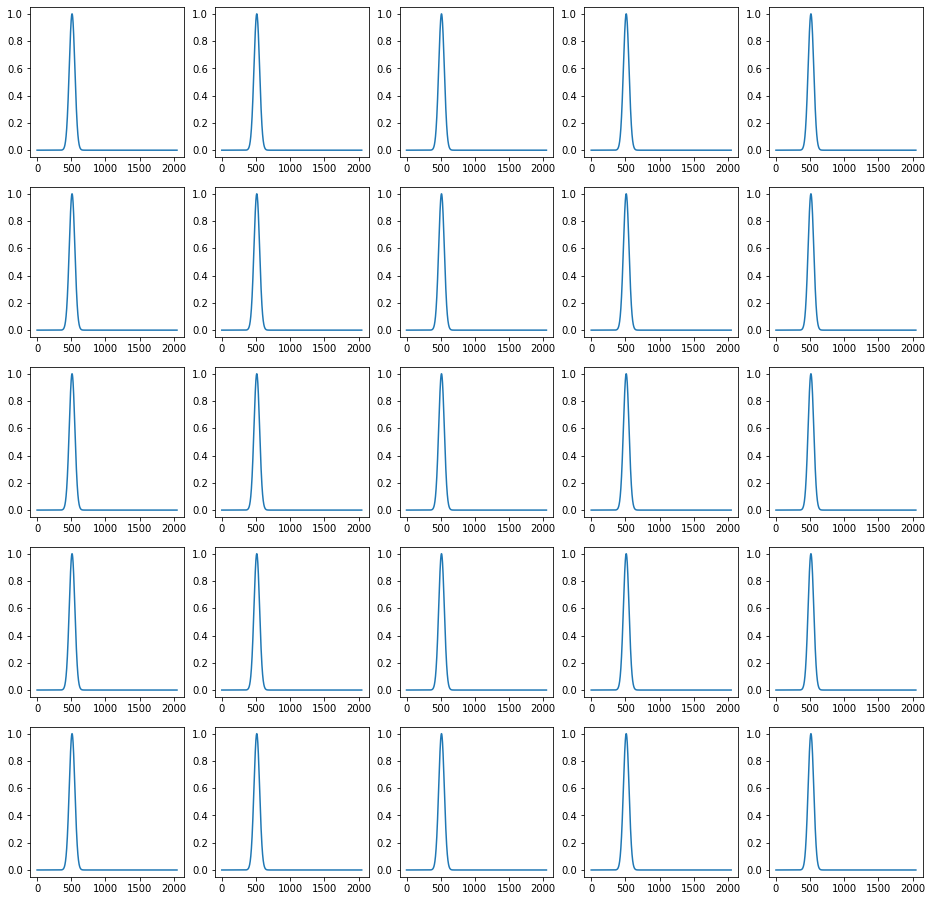

In [250]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16))

for x, ax in zip(X[:], axes.reshape(-1)):
    
    ax.plot(x[:, 0])

In [251]:
from tensorflow.keras import layers


def conv_block(x, filters, kernel_size, stride, batch_norm=True):
    x = layers.Conv1D(filters, kernel_size, stride, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(x, filters, kernel_size, stride, pool_size=2):
    x = conv_block(x, filters, kernel_size, stride)
    #x = layers.MaxPool1D(pool_size)(x)
    return x

def UNet():
    
    inputs = layers.Input((2048, 1), dtype='float32')
    x = inputs
    
    x = encoder_block(x, 64, 5, 1)
    x = encoder_block(x, 64, 5, 2)
    x = encoder_block(x,  128, 5, 1)
    x = encoder_block(x, 128, 5, 2)
    x = encoder_block(x, 256, 5, 1)
    x = encoder_block(x, 256, 5, 2)
    x = encoder_block(x,  512, 5, 1)
    x = encoder_block(x, 512, 5, 2)
    
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    
    x = layers.Dense(2, activation='linear')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
# Loss should be categorical crossentropy (with from_logits=True) (no need to customize)
        

In [252]:
model = UNet()
model.summary()

Model: "functional_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 2048, 1)]         0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 2048, 64)          384       
_________________________________________________________________
activation_281 (Activation)  (None, 2048, 64)          0         
_________________________________________________________________
batch_normalization_273 (Bat (None, 2048, 64)          256       
_________________________________________________________________
conv1d_282 (Conv1D)          (None, 1024, 64)          20544     
_________________________________________________________________
activation_282 (Activation)  (None, 1024, 64)          0         
_________________________________________________________________
batch_normalization_274 (Bat (None, 1024, 64)       

In [254]:
model = UNet()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X[:290], y[:290], epochs=15, verbose=1)

Epoch 1/15
1/1 [==============================] - 0s 1ms/step - loss: 0.6931
Epoch 2/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6902
Epoch 3/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6840
Epoch 4/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6765
Epoch 5/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6673
Epoch 6/15
1/1 [==============================] - 0s 1ms/step - loss: 0.6562
Epoch 7/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6432
Epoch 8/15
1/1 [==============================] - 0s 1ms/step - loss: 0.6286
Epoch 9/15
1/1 [==============================] - 0s 1ms/step - loss: 0.6127
Epoch 10/15
1/1 [==============================] - 0s 1ms/step - loss: 0.5963
Epoch 11/15
1/1 [==============================] - 0s 1ms/step - loss: 0.5806
Epoch 12/15
1/1 [==============================] - 0s 1ms/step - loss: 0.5670
Epoch 13/15
1/1 [==============================] - 0s 1ms/step - loss: 0.

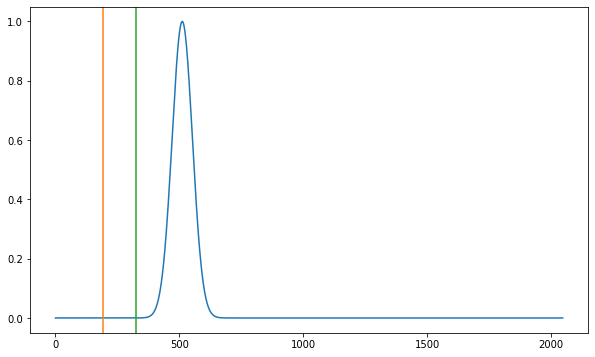

In [246]:
plt.figure(figsize=(10, 6))

ID = 292

prediction = model.predict(X[ID][None])[0]
left, right = encoder.decode(tf.nn.sigmoid(prediction))

plt.plot(X[ID])
plt.axvline(left, color='C1')
plt.axvline(right, color='C2')

In [ ]:
plt.figure(figsize=(10, 6))

ID = 295

prediction = model.predict(X[ID][None])[0]
pos = np.where(tf.nn.sigmoid(prediction) > 0.5)[0]

plt.plot(X[ID])
plt.scatter(pos, [-.1] * len(pos), color='C1', s=5)

plt.ylim(-10, 10)